# PWG2. Atari Space Invader | DQN

> 本文的 [代码仓库](https://github.com/Alexbeast-CN/Uob_Robotics/tree/main/DRL/PWG/PWG2) 位于 Github，具体的代码实现请查看 [Colab 笔记本](https://colab.research.google.com/drive/1n0kyQJMHU2TTb-cZS0BgHAJsBfFg_AYh#scrollTo=08EF8L72NOM4)

![](./pics/blue.png)

## 0. 准备

> 这里由于我自己的电脑没有 GPU 因此我选择在 Colab 上运行，代码也只在 Colab 上测试过。我的 Colab 笔记本位于 [PWG2_Play_Atari](https://colab.research.google.com/drive/1n0kyQJMHU2TTb-cZS0BgHAJsBfFg_AYh?usp=sharing)，本文的 Github 页面位于 [PWG2](https://github.com/Alexbeast-CN/Uob_Robotics/tree/main/DRL/PWG/PWG2)

Atari 是老版游戏机上的那种小游戏。这里我们使用 gym 作为载体，让强化学习的 agent 通过直接读取游戏的画面作为输入，来玩小游戏，并获取游戏内置的高分奖励。

在开始之前，需要先提醒各位的是，Gym 的 atari 只在 Linux 和 MacOS 系统可以使用。如果你使用的是 Windows 电脑，那么则需要使用特别的安装方法：[How to Install OpenAI Gym in a Windows Environment](https://towardsdatascience.com/how-to-install-openai-gym-in-a-windows-environment-338969e24d30)。或者使用全平台通用的 docker，可以在 [Github | ALE/docker](https://github.com/mgbellemare/Arcade-Learning-Environment/tree/8a6c7701542b1c1aceb24e95f65df04d85900b63/docker) 获取 dockerfile

另外对于 Windows 用户，我建议使用 WLS2 即 (Windows subsystem for Linux) 具体的使用方法。具体操作看视频：

- 如果你是 Win10 系统 [Youtube | Developing on Windows with WSL2 (Subsystem for Linux), VS Code, Docker, and the Terminal](https://www.youtube.com/watch?v=A0eqZujVfYU&ab_channel=ScottHanselman)
- 如果你是 Win11 系统 [Youtube | Windows 11 runs Graphical Linux Apps out of the box with WSLg](https://www.youtube.com/watch?v=b1YBx1L8op4&t=404s&ab_channel=ScottHanselman)

此外如果你是 Win11 的系统，那么恭喜你，通过 WLS2 你的电脑可以无缝在 Windows 图形化应用和 Linux 图形化应用之间切换。且可以直接使用 Vscode 连接 Linux 虚拟机。具体操作方法请查看 [Visual Studio Code Remote - WSL](https://code.visualstudio.com/docs/remote/wsl)

关于游戏这里作为演示，我选择太空侵略者 [SpaceInvaders](https://gym.openai.com/envs/SpaceInvaders-v0/)，但根据 DeepMind 2015 年的 Nature 论文 [Human-level control through deep reinforcement learning](https://www.nature.com/articles/nature14236?wm=book_wap_0005)，一套 DRL 算法在不该超参的情况下可以直接训练大多数 Atari 游戏。关于算法，我打算直接使用 [Stable Baselines3](https://stable-baselines3.readthedocs.io/en/master/) 提供的 DQN 算法作为模型进行训练。

为了让 Atari 能够在 Colab 上正常运行，我们需要先让 gym[Atari] 获取Colab 的 ROM。具体操作如下：

> 该段代码来自此 [Github](https://github.com/openai/atari-py/issues/83)

In [ ]:
! wget http://www.atarimania.com/roms/Roms.rar
! mkdir /content/ROM/
! unrar e /content/Roms.rar /content/ROM/ -y
! python -m atari_py.import_roms /content/ROM/

但是在正常的 Linux 或 Mac 系统下，只需要从 ALE 库中导入游戏即可，不需要执行上面的命令。而是使用下面的代码：

In [5]:
!pip install ale-py
from ale_py.roms import SpaceInvaders

另外由于 Colab 无法弹窗展示游戏画面，因此需要写一个函数将游戏画面保存为视频。关于这段代码请查看我的 [Colab 笔记本](https://colab.research.google.com/drive/1n0kyQJMHU2TTb-cZS0BgHAJsBfFg_AYh#scrollTo=08EF8L72NOM4)

至此，准备工作全部完成，开始具体的实验操作。

![](./pics/green.png)

## 1. 了解游戏

首先我们利用下面的代码来查看游戏的基本信息：如动作，状态，奖励，初始画面，及其大小。

In [4]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def query_environment(name):
  env = gym.make(name)
  spec = gym.spec(name)
  observation = env.reset()
  print(f"Action Space: {env.action_space}")
  print(f"Observation Space: {env.observation_space.shape}")
  print(f"Max Episode Steps: {spec.max_episode_steps}")
  print(f"Nondeterministic: {spec.nondeterministic}")
  print(f"Reward Range: {env.reward_range}")
  print(f"Reward Threshold: {spec.reward_threshold}")
  plt.imshow(np.array(observation))
  plt.show()


Action Space: Discrete(6)
Observation Space: (210, 160, 3)
Max Episode Steps: 10000
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: None


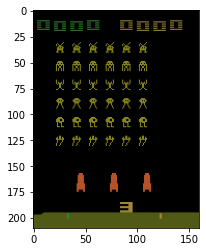

In [15]:
query_environment('SpaceInvaders-v0')

对上面的输出一一翻译：
- 动作空间：Agent 共可以采用 6 种动作。从 [ALE/SpaceInvaders-v0](https://github.com/mgbellemare/Arcade-Learning-Environment/blob/8a6c7701542b1c1aceb24e95f65df04d85900b63/src/games/supported/SpaceInvaders.cpp) 的代码中可知，这六个动作分别是：
  - 不动
  - 左移
  - 右移
  - 开火
  - 左移且开火
  - 右移且开火
- 观测空间，即画面是 RGB 三通道，大小是一个 210 x 160 大小的矩阵。
- 最大步长：10000
- 每一步都是确定的
- 奖励空间从负无穷到正无穷，但实际游戏的奖励获取自 Atari 自带的分数系统。
- 没有奖励阈值

下面我们让用随机动作试玩一下这个游戏：

In [19]:
def random_play(name):
    env = gym.make(name)
    score = 0
    env.reset()
    while True:
        env.render()
        action = env.action_space.sample()
        state, reward, done, _ = env.step(action)
        score += reward
        if done:
            env.close()
            print("Your Score at end of game is: ", score)
            break
            
random_play('SpaceInvaders-v0')

Your Score at end of game is: 45


![随机策略的游戏画面](./gifs/SpaceInvaders.gif)

![](./pics/green.png)

## 2. 创建强化学习模型

这里我选择直接从 Stable-Baselines 强化学习库中调用 DQN 算法。

> 关于 DQN 算法的 [官方说明](https://stable-baselines3.readthedocs.io/en/master/modules/dqn.html?highlight=dqn)

关于算法的详细解释请查看论文 [Playing Atari with Deep Reinforcement Learning](https://arxiv.org/abs/1312.5602)。 Q-learning 的基本原理为：

![](./pics/deep_q-learning.png)

深度 Q—NetWork 的原理为：

![](./pics/deep_q-network.png)

首先引用库文件

In [9]:
!pip install stable-baselines3[extra]
# import the DQN model form stable-baselines
from stable_baselines3 import DQN
# DummyVecEnv can help train multiple agents at the same time
from stable_baselines3.common.vec_env import DummyVecEnv
# import evaluation methdos
from stable_baselines3.common.evaluation import evaluate_policy
import os

创建参数表。

In [2]:
ENVIRONMENT = "SpaceInvaders-v0"
# Change the path to your drive
PATH = "/content/drive/MyDrive/Reinforcement_Learning/SpaceInvaders"
GAMMA = 0.99           # discount factor
BUFFER_SIZE = 100000   # replay buffer size
BATCH_SIZE = 32        # Update batch size
LR = 0.0001            # learning rate 
TAU = 0.1               # for soft update of target parameters
UPDATE_EVERY = 100     # how often to update the network
UPDATE_TARGET = 10000  # After which thershold replay to be started 
EPS_START = 0.99       # starting value of epsilon
EPS_END = 0.01         # Ending value of epsilon
EPS_DECAY = 0.01        # Rate by which epsilon to be decayed

> 注意：对模型训练的缓存为 100000，这意味着电脑至少需要 24G 的 RAM 才能带的动该模型，使用大一些的缓存通常可以获得较好的训练效果。

创建模型并设置模型的数据储存路径

In [7]:
# Create the environment
env = gym.make(ENVIRONMENT)
env = DummyVecEnv([lambda: env])

A.L.E: Arcade Learning Environment (version 0.7.4+069f8bd)
[Powered by Stella]


In [20]:
model = DQN('CnnPolicy', 
          env, learning_rate=LR, 
          buffer_size=BUFFER_SIZE, 
          learning_starts=UPDATE_TARGET, 
          batch_size=BATCH_SIZE, tau=TAU, 
          gamma= GAMMA, 
          target_update_interval=UPDATE_EVERY, 
          exploration_fraction=EPS_DECAY, 
          exploration_initial_eps=EPS_START, 
          exploration_final_eps=EPS_END, 
          tensorboard_log=PATH)

训练模型，以 10 万次为一组进行训练，每训练完一组就保存一次模型，共训练 40 次。

In [ ]:
for i in range(40):
    model.learn(total_timesteps=100000)
    model.save(f"{PATH}/model_{i}")
    evaluate_policy(model, env, n_eval_episodes=10)

![](./pics/green.png)

## 3. 结果演示

这里我们选取第 100k 次，1m 次，2.5m 次， 3m 次以及 第 4m 次的模型进行演示。

首先我们要读取模型，这里只演示读取一个模型的方法。

In [ ]:
ENVIRONMENT = "SpaceInvaders-v0"
env = gym.make(ENVIRONMENT)
env = gym.wrappers.Monitor(env, "videos", force = True)
model = DQN.load("./model_29.zip",env=env)

然后对每一个模型采样 5 次。

In [ ]:
episodes = 5
# Loop the env for 5 episodes
for episode in range(episodes):
    # Initialize the environment and get first state
    obs = env.reset()
    done = False
    sorce = 0

    while not done:
        # Render(渲染) the environment
        env.render(mode='human')
        # Random actions
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(action)
        sorce += reward
    print("Episode {}  score: {}".format(episode, sorce))
env.close()

下面是实验结果：

- 没有训练的 AI 还是个傻子

![](./gifs/SpaceInvaders.gif)

- 经过 100K 次训练后，AI 稍微会玩了，但看起来还是笨笨的，不灵活。

![](./gifs/100k_1_AdobeCreativeCloudExpress.gif)

- 经过 1m 次训练后，AI 明显变强了，并且知道了打气球可以获得更高的分数。但总体来说依然不是很灵活。

![](./gifs/1m_2_AdobeCreativeCloudExpress.gif)



- 经过 2.5m 次训练后，虽然分数没有 1m 高，但是 AI 明显变得更加灵活了。
  
![](./gifs/2_5m_1_AdobeCreativeCloudExpress.gif)

- 经过 3m 次训练后，AI 以及可以拿到很高的分数了。

![](./gifs/3m_AdobeCreativeCloudExpress.gif)

- 最后 4m 次的训练对于 AI 没有明显的帮助。

![](./gifs/4m_2_AdobeCreativeCloudExpress.gif)